## Homework 2

### Ridge regression. Quadratic features
1. Add quadratic features to data and perform stepwise subset selection
2. Plot beta values as a function of lambda in ridge regression
3. Plot train and test error as afunction of lambda

In [1]:
%matplotlib inline
# standard library
import itertools

# pandas
import pandas as pd

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.datasets

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

/home/nikitautiu/anaconda2/envs/datascience3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def pad_design_matrix(X):
    """Return the design matrix padded with 
    the constant feature"""
    aux = np.ones((X.shape[0], X.shape[1]+1))
    aux[:, 1:] = X
    return aux

def ordinary_least_squares(X, Y, l=0):
    """Return the best coefficients using OLS
    Does ridge regression if lambda is specified"""
    # the design matrix has the vectors 
    # as rows instead of cols
    X_pad = pad_design_matrix(X)
    
    # add the regularization term. unaffected if 0
    inv = np.linalg.inv(X_pad.T.dot(X_pad) + l * np.eye(X_pad.shape[1]))
    return inv.dot(X_pad.T.dot(Y))

def mse(X, beta, Y):
    # mean squared error
    return np.mean((pad_design_matrix(X).dot(beta) - Y) ** 2)

def stepwise_subset_selection(X, Y, initial=[]):
    """Stepwise traverse the best subsets of covariates 
    and yield tuples of (# of covariates, train error)
    
    Can be passed an additional argument which states which
    columns to be used initially.
    """

    used_cols = set(initial) 
    avail_cols = set(range(X.shape[1])) - used_cols # set of remaining cols

    
    for i in range(1, X.shape[1]+1):
        errs = []  # list of (err, col added) tuples
        for col in avail_cols:
            cols = list(used_cols | set([col]))
            sub_X  = X[:, cols]
            # cmpute beta and MSE
            betas = ordinary_least_squares(sub_X, Y)
            errs.append((mse(sub_X, betas, Y), col)) 
        best_result = min(errs)  # works because tuples
        used_cols |= set([best_result[1]])
        
        # yield the best result fr the current iteration
        yield (len(used_cols), best_result[0])
        
def add_quadratic_features(X):
    """Returns X with the additional quadratic features xi*xj"""
    quadr_cols = []  # list of all column prods
    for i,j in itertools.combinations(range(X.shape[1]), 2):
        # add newaxis, otherwise lose 1 dimension
        quadr_cols.append(X[:, i, np.newaxis] * X[:, j, np.newaxis])
    return np.hstack([X] + quadr_cols) # concat all

In [3]:
# import dataset                                                                                                                                                                                
data = sklearn.datasets.load_diabetes()
X = data['data']
Y = data['target']

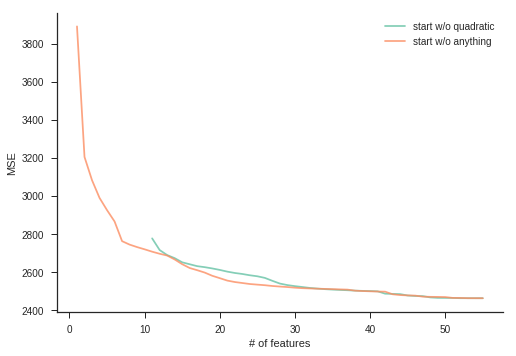

In [4]:
# plot quadratic features
# first with an empty set of features 
# then with all the existing features already in place
stepwise_results = list(zip(*stepwise_subset_selection(add_quadratic_features(X), Y,range(10))))
stepwise_results2 = list(zip(*stepwise_subset_selection(add_quadratic_features(X), Y)))

plt.plot(stepwise_results[0], stepwise_results[1], '-', alpha=0.8, label="start w/o quadratic")
plt.plot(stepwise_results2[0], stepwise_results2[1], '-', alpha=0.8, label="start w/o anything")
plt.legend()
plt.xlabel('# of features')
plt.ylabel('MSE')
sns.despine()

In [5]:
def get_betas(X, Y, lambdas):
    """Returns vectors of the values of beta
    for each of the lambda values given"""
    betas_vect = []
    for l in lambdas:
        # add the betas to the vector
        betas_vect.append(ordinary_least_squares(X, Y, l))
    
    return list(np.vstack(betas_vect).T)

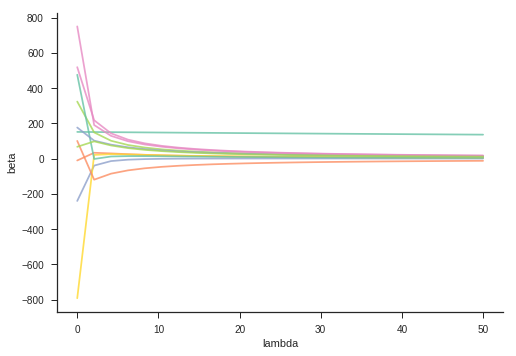

In [6]:
# plot betas with respect to lambda
lambdas = np.linspace(0, 50, 25)
beta_vects = get_betas(X, Y, lambdas)

ax = plt.subplot()
for i, beta in enumerate(beta_vects):
    # plot each beta with lambda on the x axis
    plt.plot(lambdas, beta, alpha=0.8,  label='b{}'.format(i))
    
plt.xlabel('lambda')
plt.ylabel('beta')
sns.despine()

In [7]:
def train_test_split(X, Y):
    """Return two sets of data, split 80/20"""
    train_samps = int(X.shape[0] * 0.8)
    return (X[:train_samps, :], Y[:train_samps],
            X[train_samps:, :], Y[train_samps:])

def get_err_by_lambda(X_train, Y_train, X_test, Y_test, lambdas):
    """Return arrays of the train and test error,
    respectively, for the given lambdas"""
    
    errs = []
    for l in lambdas:
        beta = ordinary_least_squares(X_train, Y_train, l)
        # compute, both the train and the test eror with the same lambda
        errs.append((mse(X_train, beta, Y_train),
                     mse(X_test, beta, Y_test)))
    
    return list(zip(*errs))

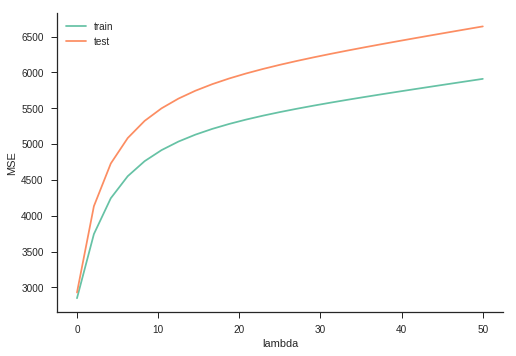

In [8]:
# plot the errors
X_train, Y_train, X_test, Y_test = train_test_split(X, Y)
lambdas = np.linspace(0, 50, 25)
train_err, test_err = get_err_by_lambda(X_train, Y_train, X_test, Y_test, lambdas)

plt.plot(lambdas, train_err, label='train')
plt.plot(lambdas, test_err, label='test')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.legend()
sns.despine()